In [20]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats

# Function to generate random dates
def random_dates(start, end, n=10):
    return [start + timedelta(days=np.random.randint(0, (end - start).days)) for _ in range(n)]

# Parameters
num_records = 10000
start_date = datetime.now() - timedelta(days=4*365)
end_date = datetime.now()

# Expanded categories
business_lines = [
    "Retail", "Corporate Banking", "Investment Banking", "Insurance",
    "Wealth Management", "Asset Management", "Private Banking",
    "Credit Card Services", "Mortgage Lending", "Financial Advisory"
]

event_types = [
    "Fraud", "System Failure", "Theft", "Compliance", "Natural Disaster",
    "Cyber Attack", "Market Risk", "Operational Error", "Vendor Risk", "Regulatory Violation"
]

# Generate data
data = {
    "Date": random_dates(start_date, end_date, num_records),
    "Unique Event ID": [f"EID{str(i).zfill(5)}" for i in range(num_records)],
    "Event Type": np.random.choice(event_types, num_records),
    "Business Line": np.random.choice(business_lines, num_records),
    "Event Description": np.random.choice(
        [
            "Unauthorized transaction", "Server downtime", "Lost assets", 
            "Regulatory fines", "Data breach", "Network failure", 
            "Inadequate compliance", "Financial misstatement", 
            "Supplier issues", "Internal fraud"
        ],
        num_records
    ),
    "Net Loss Amount": np.random.choice(
        [np.random.uniform(-10000, 0) for _ in range(num_records // 2)] + 
        [np.random.uniform(0, 10000) for _ in range(num_records // 2)],
        num_records
    )
}

# Create DataFrame
df = pd.DataFrame(data)

# Add a Year column
df['Year'] = df['Date'].dt.year

# Function to fit distribution and calculate VaR for the specified confidence level
def fit_distribution_and_calculate_var(data):
    confidence = 0.999  # Set to 99.9%
    var_result = {}
    # Filter only negative net loss amounts for fitting
    negative_losses = data[data['Net Loss Amount'] < 0]
    
    if negative_losses.empty:
        return {confidence: np.nan}  # Return NaN if no data

    # Fit a log-normal distribution to the net loss amounts (inverted for fitting)
    shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)  
    # Calculate VaR for the specified confidence level
    var = stats.lognorm.ppf(confidence, shape, loc=loc, scale=scale)
    var_result[confidence] = var
    return var_result

# Group by Year, Business Line, and Event Type, then apply the VaR calculation
result = df.groupby(['Year', 'Business Line', 'Event Type']).apply(
    lambda x: fit_distribution_and_calculate_var(x)[0.999]
).reset_index()

result.columns = ['Year', 'Business Line', 'Event Type', 'VaR (99.9%)']

# Calculate total loss amount and count of event IDs for each group
agg_result = df.groupby(['Year', 'Business Line', 'Event Type']).agg(
    Total_Loss_Amount=('Net Loss Amount', 'sum'),
    Event_Count=('Unique Event ID', 'count')
).reset_index()

# Merge VaR results with aggregated results
final_result = pd.merge(agg_result, result, on=['Year', 'Business Line', 'Event Type'], how='left')

# Display the final results
print(final_result)

# Optionally, save results to a CSV
final_result.to_csv('lda_var_results_with_totals_99.9.csv', index=False)


C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


     Year      Business Line            Event Type  Total_Loss_Amount  \
0    2020   Asset Management            Compliance        1210.646097   
1    2020   Asset Management          Cyber Attack       10804.421627   
2    2020   Asset Management                 Fraud        2488.143000   
3    2020   Asset Management           Market Risk       -6240.615813   
4    2020   Asset Management      Natural Disaster      -15638.488274   
..    ...                ...                   ...                ...   
488  2024  Wealth Management     Operational Error       14124.943368   
489  2024  Wealth Management  Regulatory Violation       -2182.151802   
490  2024  Wealth Management        System Failure       -6622.756005   
491  2024  Wealth Management                 Theft      -18160.713335   
492  2024  Wealth Management           Vendor Risk       18175.076440   

     Event_Count   VaR (99.9%)  
0              4  5.108877e+03  
1              2           NaN  
2              2  1.6062

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_4984\3977692581.py:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['Year', 'Business Line', 'Event Type']).apply(


In [21]:
# Merge VaR results with aggregated results
final_result = pd.merge(agg_result, result, on=['Year', 'Business Line', 'Event Type'], how='left')

# Remove rows with NaN in the VaR (99.9%) column
final_result = final_result.dropna(subset=['VaR (99.9%)']).reset_index(drop=True)

# Display the final results
print(final_result)

# Optionally, save results to a CSV
final_result.to_csv('lda_var_results_with_totals_99.9.csv', index=False)


     Year      Business Line            Event Type  Total_Loss_Amount  \
0    2020   Asset Management            Compliance        1210.646097   
1    2020   Asset Management                 Fraud        2488.143000   
2    2020   Asset Management           Market Risk       -6240.615813   
3    2020   Asset Management      Natural Disaster      -15638.488274   
4    2020   Asset Management  Regulatory Violation       -1661.368351   
..    ...                ...                   ...                ...   
466  2024  Wealth Management     Operational Error       14124.943368   
467  2024  Wealth Management  Regulatory Violation       -2182.151802   
468  2024  Wealth Management        System Failure       -6622.756005   
469  2024  Wealth Management                 Theft      -18160.713335   
470  2024  Wealth Management           Vendor Risk       18175.076440   

     Event_Count   VaR (99.9%)  
0              4  5.108877e+03  
1              2  1.606215e+03  
2              2  3.0737

In [22]:
# Calculate mean and standard deviation of VaR (99.9%)
mean_var = final_result['VaR (99.9%)'].mean()
std_var = final_result['VaR (99.9%)'].std()

# Define the upper and lower thresholds
upper_threshold = mean_var + 3 * std_var
lower_threshold = mean_var - 3 * std_var

# Identify outliers based on the +3/-3 standard deviation approach
outliers = final_result[(final_result['VaR (99.9%)'] > upper_threshold) |
                        (final_result['VaR (99.9%)'] < lower_threshold)]

# Display the outliers
print("Outliers based on +3/-3 Standard Deviation approach:")
print(outliers)


Outliers based on +3/-3 Standard Deviation approach:
    Year Business Line         Event Type  Total_Loss_Amount  Event_Count  \
60  2020        Retail  Operational Error        3033.045202            2   

     VaR (99.9%)  
60  2.300782e+42  


In [23]:
outliers

,Year,Business Line,Event Type,Total_Loss_Amount,Event_Count,VaR (99.9%)
60,2020,Retail,Operational Error,3033.045202,2,2.300782e+42


In [24]:
import pandas as pd

# Assuming 'df' is the DataFrame with your data

# IQR Method to identify outliers
Q1 = final_result['VaR (99.9%)'].quantile(0.25)
Q3 = final_result['VaR (99.9%)'].quantile(0.75)
IQR = Q3 - Q1

# Outlier criteria for IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = final_result[(final_result['VaR (99.9%)'] < lower_bound) | (final_result['VaR (99.9%)'] > upper_bound)]

# Standard Deviation Method to identify outliers
mean = final_result['VaR (99.9%)'].mean()
std_dev = final_result['VaR (99.9%)'].std()

# Outlier criteria for Standard Deviation (±3 standard deviations)
lower_bound_sd = mean - 3 * std_dev
upper_bound_sd = mean + 3 * std_dev

outliers_sd = final_result[(final_result['VaR (99.9%)'] < lower_bound_sd) | (final_result['VaR (99.9%)'] > upper_bound_sd)]

# Print outliers
print("Outliers using IQR method:")
print(outliers_iqr)


Outliers using IQR method:
     Year      Business Line            Event Type  Total_Loss_Amount  \
2    2020   Asset Management           Market Risk       -6240.615813   
3    2020   Asset Management      Natural Disaster      -15638.488274   
4    2020   Asset Management  Regulatory Violation       -1661.368351   
6    2020   Asset Management           Vendor Risk        -456.826374   
9    2020  Corporate Banking  Regulatory Violation       -9618.185864   
..    ...                ...                   ...                ...   
447  2024    Private Banking  Regulatory Violation       20876.893331   
455  2024             Retail      Natural Disaster       20171.496026   
456  2024             Retail     Operational Error        3843.155014   
459  2024             Retail                 Theft        7888.787398   
466  2024  Wealth Management     Operational Error       14124.943368   

     Event_Count   VaR (99.9%)  
2              2  3.073744e+21  
3              3  4.393410e+22

In [25]:
outliers_iqr

,Year,Business Line,Event Type,Total_Loss_Amount,Event_Count,VaR (99.9%)
2,2020,Asset Management,Market Risk,-6240.615813,2,3.073744e+21
3,2020,Asset Management,Natural Disaster,-15638.488274,3,4.393410e+22
4,2020,Asset Management,Regulatory Violation,-1661.368351,3,3.381890e+19
6,2020,Asset Management,Vendor Risk,-456.826374,4,6.261924e+19
9,2020,Corporate Banking,Regulatory Violation,-9618.185864,3,4.155746e+21
...,...,...,...,...,...,...
447,2024,Private Banking,Regulatory Violation,20876.893331,15,4.247910e+20
455,2024,Retail,Natural Disaster,20171.496026,22,3.078057e+18
456,2024,Retail,Operational Error,3843.155014,16,6.024018e+18
459,2024,Retail,Theft,7888.787398,26,5.091515e+18


In [26]:
outliers_sd

,Year,Business Line,Event Type,Total_Loss_Amount,Event_Count,VaR (99.9%)
60,2020,Retail,Operational Error,3033.045202,2,2.300782e+42


In [8]:
import pandas as pd

# Assuming 'df' is the DataFrame with your data

# IQR Method to identify outliers
Q1 = final_result['Total_Loss_Amount'].quantile(0.25)
Q3 = final_result['Total_Loss_Amount'].quantile(0.75)
IQR = Q3 - Q1

# Outlier criteria for IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = final_result[(final_result['Total_Loss_Amount'] < lower_bound) | (final_result['Total_Loss_Amount'] > upper_bound)]

# Standard Deviation Method to identify outliers
mean = final_result['Total_Loss_Amount'].mean()
std_dev = final_result['Total_Loss_Amount'].std()

# Outlier criteria for Standard Deviation (±3 standard deviations)
lower_bound_sd = mean - 3 * std_dev
upper_bound_sd = mean + 3 * std_dev

outliers_sd = final_result[(final_result['Total_Loss_Amount'] < lower_bound_sd) | (final_result['Total_Loss_Amount'] > upper_bound_sd)]

# Print outliers
print("Outliers using IQR method:")
print(outliers_iqr)

print("Outliers using SD method:")
print(outliers_sd)


Outliers using IQR method:
     Year         Business Line        Event Type  Total_Loss_Amount  \
119  2021             Insurance    System Failure       61607.458538   
151  2021       Private Banking       Vendor Risk      -65714.900203   
154  2021                Retail             Fraud       75222.410965   
176  2022      Asset Management  Natural Disaster      -76211.975059   
189  2022     Corporate Banking    System Failure       72972.249028   
222  2022    Investment Banking        Compliance      -68691.687154   
245  2022       Private Banking       Market Risk      -68813.050017   
395  2024  Credit Card Services       Market Risk      -73392.734739   
444  2024       Private Banking             Fraud       68976.991082   
469  2024     Wealth Management    System Failure      -74790.572367   

     Event_Count   VaR (99.9%)  
119           31  5.730600e+16  
151           34  1.578606e+04  
154           27  2.083138e+19  
176           34  1.419408e+04  
189           2

In [9]:
outliers_iqr

,Year,Business Line,Event Type,Total_Loss_Amount,Event_Count,VaR (99.9%)
119,2021,Insurance,System Failure,61607.458538,31,5.730600e+16
151,2021,Private Banking,Vendor Risk,-65714.900203,34,1.578606e+04
154,2021,Retail,Fraud,75222.410965,27,2.083138e+19
176,2022,Asset Management,Natural Disaster,-76211.975059,34,1.419408e+04
189,2022,Corporate Banking,System Failure,72972.249028,27,6.027087e+17
222,2022,Investment Banking,Compliance,-68691.687154,31,1.359128e+04
245,2022,Private Banking,Market Risk,-68813.050017,19,1.483447e+04
395,2024,Credit Card Services,Market Risk,-73392.734739,29,1.519848e+04
444,2024,Private Banking,Fraud,68976.991082,22,1.027295e+19
469,2024,Wealth Management,System Failure,-74790.572367,29,1.457145e+04


In [10]:
outliers_sd

,Year,Business Line,Event Type,Total_Loss_Amount,Event_Count,VaR (99.9%)
154,2021,Retail,Fraud,75222.410965,27,2.083138e+19


In [27]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats

# Function to generate random dates
def random_dates(start, end, n=10):
    return [start + timedelta(days=np.random.randint(0, (end - start).days)) for _ in range(n)]

# Parameters
num_records = 10000
start_date = datetime.now() - timedelta(days=4*365)
end_date = datetime.now()

# Expanded categories
business_lines = [
    "Retail", "Corporate Banking", "Investment Banking", "Insurance",
    "Wealth Management", "Asset Management", "Private Banking",
    "Credit Card Services", "Mortgage Lending", "Financial Advisory"
]

event_types = [
    "Fraud", "System Failure", "Theft", "Compliance", "Natural Disaster",
    "Cyber Attack", "Market Risk", "Operational Error", "Vendor Risk", "Regulatory Violation"
]

# Generate data
data = {
    "Date": random_dates(start_date, end_date, num_records),
    "Unique Event ID": [f"EID{str(i).zfill(5)}" for i in range(num_records)],
    "Event Type": np.random.choice(event_types, num_records),
    "Business Line": np.random.choice(business_lines, num_records),
    "Event Description": np.random.choice(
        [
            "Unauthorized transaction", "Server downtime", "Lost assets", 
            "Regulatory fines", "Data breach", "Network failure", 
            "Inadequate compliance", "Financial misstatement", 
            "Supplier issues", "Internal fraud"
        ],
        num_records
    ),
    "Net Loss Amount": np.random.choice(
        [np.random.uniform(-10000, 0) for _ in range(num_records // 2)] + 
        [np.random.uniform(0, 10000) for _ in range(num_records // 2)],
        num_records
    )
}

# Create DataFrame
df = pd.DataFrame(data)

# Function to perform Monte Carlo simulation for VaR calculation
def monte_carlo_var(data, num_simulations=10000, confidence=0.99):
    # Fit a distribution (Normal distribution for simplicity in this example)
    mu, sigma = stats.norm.fit(data)  # Fit data to normal distribution
    
    # Generate simulations using the fitted distribution
    simulations = np.random.normal(mu, sigma, num_simulations)
    
    # Calculate the VaR at the specified confidence level
    var_value = np.percentile(simulations, (1 - confidence) * 100)  # Lower tail for losses
    
    return var_value

# Extract Year from Date for grouping
df['Year'] = df['Date'].dt.year

# Group by Year, Business Line, and Event Type
agg_data = df.groupby(['Year', 'Business Line', 'Event Type']).agg(
    Event_Count=('Unique Event ID', 'count'),
    Total_Net_Loss=('Net Loss Amount', 'sum')
).reset_index()

# Calculate VaR for each group
agg_data['VaR'] = agg_data['Total_Net_Loss'].apply(lambda x: monte_carlo_var(df[df['Year'] == agg_data['Year'].iloc[0]]['Net Loss Amount']))

# Display the final results
print(agg_data)

# Optionally, save results to a CSV
agg_data.to_csv('montecarlo_var_summary.csv', index=False)


     Year      Business Line            Event Type  Event_Count  \
0    2020   Asset Management            Compliance            5   
1    2020   Asset Management          Cyber Attack            3   
2    2020   Asset Management                 Fraud            3   
3    2020   Asset Management           Market Risk            2   
4    2020   Asset Management      Natural Disaster            1   
..    ...                ...                   ...          ...   
491  2024  Wealth Management     Operational Error           30   
492  2024  Wealth Management  Regulatory Violation           16   
493  2024  Wealth Management        System Failure           21   
494  2024  Wealth Management                 Theft           27   
495  2024  Wealth Management           Vendor Risk           31   

     Total_Net_Loss           VaR  
0      -9638.868529 -13911.583198  
1       3636.586819 -13658.007677  
2       3800.320688 -13620.443310  
3       7347.275616 -13840.495845  
4       1913.35

In [28]:
agg_data

,Year,Business Line,Event Type,Event_Count,Total_Net_Loss,VaR
0,2020,Asset Management,Compliance,5,-9638.868529,-13911.583198
1,2020,Asset Management,Cyber Attack,3,3636.586819,-13658.007677
2,2020,Asset Management,Fraud,3,3800.320688,-13620.443310
3,2020,Asset Management,Market Risk,2,7347.275616,-13840.495845
4,2020,Asset Management,Natural Disaster,1,1913.350126,-13617.596702
...,...,...,...,...,...,...
491,2024,Wealth Management,Operational Error,30,60387.528897,-13843.651553
492,2024,Wealth Management,Regulatory Violation,16,10931.889072,-13919.744482
493,2024,Wealth Management,System Failure,21,5797.003098,-13652.445200
494,2024,Wealth Management,Theft,27,22394.169183,-13509.005016


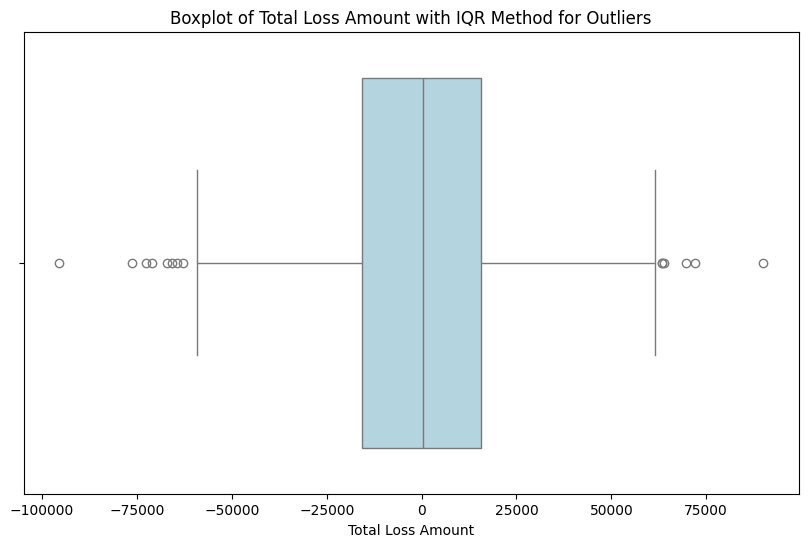

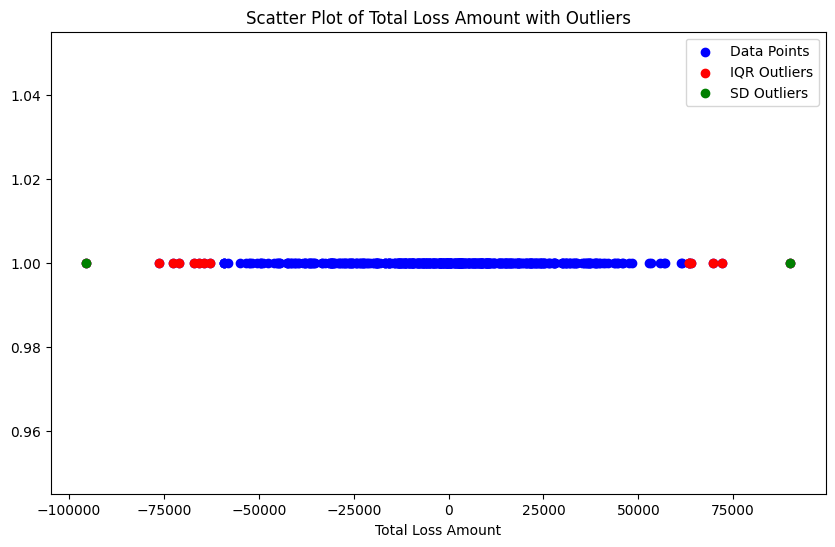

Outliers using IQR method:
     Year         Business Line            Event Type  Total_Loss_Amount  \
84   2021     Corporate Banking           Market Risk      -67128.319547   
99   2021  Credit Card Services                 Theft       63255.566749   
129  2021    Investment Banking                 Theft       72118.468195   
185  2022     Corporate Banking      Natural Disaster       69550.972465   
218  2022             Insurance        System Failure      -62891.174848   
231  2022      Mortgage Lending            Compliance      -64549.193540   
237  2022      Mortgage Lending  Regulatory Violation      -65725.835337   
304  2023    Financial Advisory           Market Risk       63230.748207   
352  2023                Retail          Cyber Attack      -72511.770861   
359  2023                Retail                 Theft       90062.943431   
372  2024      Asset Management          Cyber Attack      -71173.776993   
411  2024             Insurance            Compliance       6

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'final_result' is the DataFrame with your data

# IQR Method to identify outliers
Q1 = final_result['Total_Loss_Amount'].quantile(0.25)
Q3 = final_result['Total_Loss_Amount'].quantile(0.75)
IQR = Q3 - Q1

# Outlier criteria for IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = final_result[(final_result['Total_Loss_Amount'] < lower_bound) | (final_result['Total_Loss_Amount'] > upper_bound)]

# Standard Deviation Method to identify outliers
mean = final_result['Total_Loss_Amount'].mean()
std_dev = final_result['Total_Loss_Amount'].std()

# Outlier criteria for Standard Deviation (±3 standard deviations)
lower_bound_sd = mean - 3 * std_dev
upper_bound_sd = mean + 3 * std_dev

outliers_sd = final_result[(final_result['Total_Loss_Amount'] < lower_bound_sd) | (final_result['Total_Loss_Amount'] > upper_bound_sd)]

# Plotting

# Boxplot for IQR method
plt.figure(figsize=(10, 6))
sns.boxplot(x=final_result['Total_Loss_Amount'], color='lightblue')
plt.title('Boxplot of Total Loss Amount with IQR Method for Outliers')
plt.xlabel('Total Loss Amount')
plt.show()

# Scatter plot to visualize data points and outliers
plt.figure(figsize=(10, 6))

# Scatter plot of the entire dataset
plt.scatter(final_result['Total_Loss_Amount'], [1] * len(final_result), label='Data Points', color='blue')

# Highlight outliers from IQR method
plt.scatter(outliers_iqr['Total_Loss_Amount'], [1] * len(outliers_iqr), label='IQR Outliers', color='red')

# Highlight outliers from SD method
plt.scatter(outliers_sd['Total_Loss_Amount'], [1] * len(outliers_sd), label='SD Outliers', color='green')

plt.title('Scatter Plot of Total Loss Amount with Outliers')
plt.xlabel('Total Loss Amount')
plt.legend()
plt.show()

# Print outliers for IQR and SD
print("Outliers using IQR method:")
print(outliers_iqr)

print("Outliers using SD method:")
print(outliers_sd)


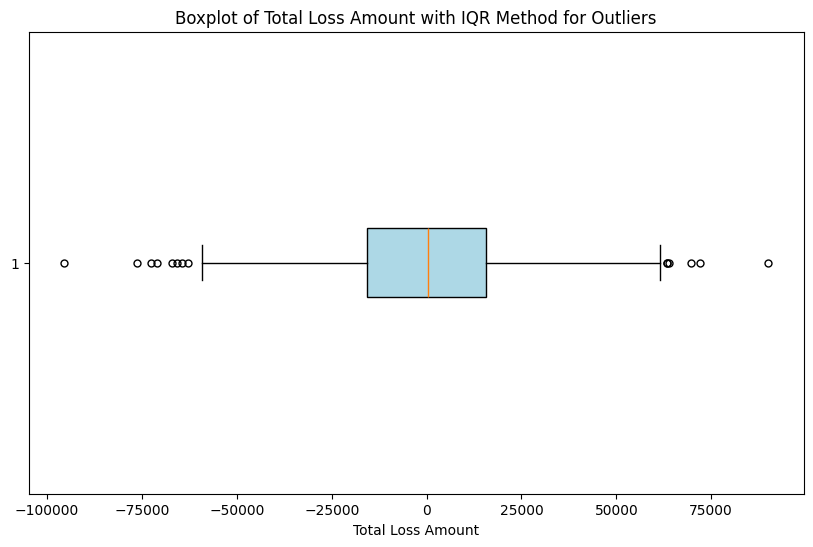

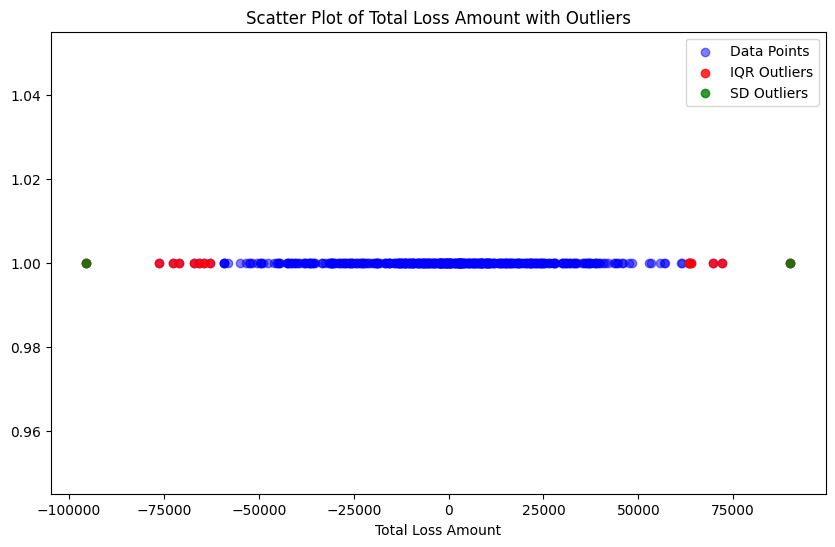

Outliers using IQR method:
     Year         Business Line            Event Type  Total_Loss_Amount  \
84   2021     Corporate Banking           Market Risk      -67128.319547   
99   2021  Credit Card Services                 Theft       63255.566749   
129  2021    Investment Banking                 Theft       72118.468195   
185  2022     Corporate Banking      Natural Disaster       69550.972465   
218  2022             Insurance        System Failure      -62891.174848   
231  2022      Mortgage Lending            Compliance      -64549.193540   
237  2022      Mortgage Lending  Regulatory Violation      -65725.835337   
304  2023    Financial Advisory           Market Risk       63230.748207   
352  2023                Retail          Cyber Attack      -72511.770861   
359  2023                Retail                 Theft       90062.943431   
372  2024      Asset Management          Cyber Attack      -71173.776993   
411  2024             Insurance            Compliance       6

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'final_result' is the DataFrame with your data

# IQR Method to identify outliers
Q1 = final_result['Total_Loss_Amount'].quantile(0.25)
Q3 = final_result['Total_Loss_Amount'].quantile(0.75)
IQR = Q3 - Q1

# Outlier criteria for IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = final_result[(final_result['Total_Loss_Amount'] < lower_bound) | (final_result['Total_Loss_Amount'] > upper_bound)]

# Standard Deviation Method to identify outliers
mean = final_result['Total_Loss_Amount'].mean()
std_dev = final_result['Total_Loss_Amount'].std()

# Outlier criteria for Standard Deviation (±3 standard deviations)
lower_bound_sd = mean - 3 * std_dev
upper_bound_sd = mean + 3 * std_dev

outliers_sd = final_result[(final_result['Total_Loss_Amount'] < lower_bound_sd) | (final_result['Total_Loss_Amount'] > upper_bound_sd)]

# Plotting with matplotlib

# 1. Boxplot for IQR Method
plt.figure(figsize=(10, 6))
plt.boxplot(final_result['Total_Loss_Amount'], vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='black'),
            flierprops=dict(marker='o', color='red', markersize=5))
plt.title('Boxplot of Total Loss Amount with IQR Method for Outliers')
plt.xlabel('Total Loss Amount')
plt.show()

# 2. Scatter Plot to visualize outliers (IQR and SD Methods)
plt.figure(figsize=(10, 6))

# Scatter plot of the entire dataset
plt.scatter(final_result['Total_Loss_Amount'], np.ones(len(final_result)), label='Data Points', color='blue', alpha=0.5)

# Highlight outliers from IQR method
plt.scatter(outliers_iqr['Total_Loss_Amount'], np.ones(len(outliers_iqr)), label='IQR Outliers', color='red', alpha=0.8)

# Highlight outliers from SD method
plt.scatter(outliers_sd['Total_Loss_Amount'], np.ones(len(outliers_sd)), label='SD Outliers', color='green', alpha=0.8)

plt.title('Scatter Plot of Total Loss Amount with Outliers')
plt.xlabel('Total Loss Amount')
plt.legend()
plt.show()

# Print outliers for IQR and SD
print("Outliers using IQR method:")
print(outliers_iqr)

print("Outliers using SD method:")
print(outliers_sd)


In [32]:
outliers_iqr

,Year,Business Line,Event Type,Total_Loss_Amount,Event_Count,VaR (99.9%)
84,2021,Corporate Banking,Market Risk,-67128.319547,26,1.307351e+04
99,2021,Credit Card Services,Theft,63255.566749,30,1.744183e+17
129,2021,Investment Banking,Theft,72118.468195,27,1.439503e+16
185,2022,Corporate Banking,Natural Disaster,69550.972465,23,1.338992e+19
218,2022,Insurance,System Failure,-62891.174848,24,1.399714e+04
231,2022,Mortgage Lending,Compliance,-64549.193540,26,1.518778e+04
237,2022,Mortgage Lending,Regulatory Violation,-65725.835337,22,1.441068e+04
304,2023,Financial Advisory,Market Risk,63230.748207,32,2.282382e+18
352,2023,Retail,Cyber Attack,-72511.770861,28,1.371617e+04
359,2023,Retail,Theft,90062.943431,33,4.734702e+16


In [37]:
import pandas as pd
import numpy as np

# Create a dummy operational risk dataset
np.random.seed(42)

data = {
    'Date': pd.date_range(start='2020-01-01', periods=100, freq='D'),
    'Business Line': np.random.choice(['Retail', 'Corporate Banking', 'Insurance'], size=100),
    'Event Type': np.random.choice(['Fraud', 'System Failure', 'Theft', 'Compliance'], size=100),
    'Net Loss Amount': np.random.uniform(0, 10000, 100)  # Simulating loss amounts
}

df = pd.DataFrame(data)
df.to_csv('operational_risk_dataset.csv', index=False)  # Save as CSV for later use


In [38]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, lognorm

# Define the calculate_var function
def calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    """
    Calculate the Value at Risk (VaR) using Monte Carlo simulation.

    Parameters:
    - frequency_lambda (float): The mean rate of events (λ) for Poisson distribution.
    - severity_shape (float): The shape parameter for log-normal distribution.
    - severity_scale (float): The scale parameter for log-normal distribution.
    - severity_loc (float): The location parameter for log-normal distribution.
    - confidence_level (float): Confidence level for VaR (default is 0.999).
    - n_simulations (int): Number of Monte Carlo simulations (default is 10000).

    Returns:
    - float: The calculated VaR at the specified confidence level.
    """
    # Simulate event counts based on Poisson
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    # Simulate severity amounts based on Log-Normal
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    
    # Calculate total loss for each simulation
    total_losses = simulated_event_counts * simulated_loss_amounts
    
    # Calculate the VaR at the specified confidence level
    var_value = np.percentile(total_losses, confidence_level * 100)
    
    return var_value

# Load the operational risk dataset
df = pd.read_csv('operational_risk_dataset.csv')

# Ensure 'Date' is in datetime format and extract the year
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

# Group by year, business line, and event type
grouped = df.groupby(['Year', 'Business Line', 'Event Type'])

# Initialize a list to hold the results
results = []

# Iterate over each group
for (year, business_line, event_type), group in grouped:
    # Calculate total net loss and event count for the group
    total_net_loss = group['Net Loss Amount'].sum()
    total_event_count = group.shape[0]
    
    # Estimate parameters for the severity (log-normal) distribution
    severity_shape, severity_loc, severity_scale = lognorm.fit(group['Net Loss Amount'], floc=0)
    
    # Calculate VaR for net loss and event count
    var_net_loss = calculate_var(total_event_count, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000)
    var_event_count = np.percentile(poisson.rvs(mu=total_event_count, size=10000), 99.9)  # Poisson VaR for event count

    # Append the results
    results.append({
        'Year': year,
        'Business Line': business_line,
        'Event Type': event_type,
        'Total Net Loss': total_net_loss,
        'Total Event Count': total_event_count,
        'VaR Net Loss': var_net_loss,
        'VaR Event Count': var_event_count
    })

# Convert the results to a DataFrame
result_df = pd.DataFrame(results)

# Display the results
print(result_df)


    Year      Business Line      Event Type  Total Net Loss  \
0   2020  Corporate Banking      Compliance    44608.999274   
1   2020  Corporate Banking           Fraud    38194.722531   
2   2020  Corporate Banking  System Failure    31769.297873   
3   2020  Corporate Banking           Theft    64190.310162   
4   2020          Insurance      Compliance    38235.007703   
5   2020          Insurance           Fraud    52359.514525   
6   2020          Insurance  System Failure    10785.284202   
7   2020          Insurance           Theft    48822.274738   
8   2020             Retail      Compliance    33824.094942   
9   2020             Retail           Fraud    20950.735438   
10  2020             Retail  System Failure    46906.481357   
11  2020             Retail           Theft    53033.960240   

    Total Event Count  VaR Net Loss  VaR Event Count  
0                   8  3.764248e+06             18.0  
1                   8  1.060660e+06             18.0  
2              

In [39]:
result_df

,Year,Business Line,Event Type,Total Net Loss,Total Event Count,VaR Net Loss,VaR Event Count
0,2020,Corporate Banking,Compliance,44608.999274,8,3.764248e+06,18.0
1,2020,Corporate Banking,Fraud,38194.722531,8,1.060660e+06,18.0
2,2020,Corporate Banking,System Failure,31769.297873,7,3.565692e+05,16.0
3,2020,Corporate Banking,Theft,64190.310162,13,4.973449e+05,25.0
4,2020,Insurance,Compliance,38235.007703,8,3.344370e+05,18.0
5,2020,Insurance,Fraud,52359.514525,8,2.503860e+05,18.0
6,2020,Insurance,System Failure,10785.284202,3,2.984511e+05,10.0
7,2020,Insurance,Theft,48822.274738,12,3.203021e+05,24.0
8,2020,Retail,Compliance,33824.094942,9,4.649981e+05,20.0
9,2020,Retail,Fraud,20950.735438,6,2.704902e+06,15.0


    Year      Business Line      Event Type  Total Net Loss  \
0   2020  Corporate Banking      Compliance    44608.999274   
1   2020  Corporate Banking           Fraud    38194.722531   
2   2020  Corporate Banking  System Failure    31769.297873   
3   2020  Corporate Banking           Theft    64190.310162   
4   2020          Insurance      Compliance    38235.007703   
5   2020          Insurance           Fraud    52359.514525   
6   2020          Insurance  System Failure    10785.284202   
7   2020          Insurance           Theft    48822.274738   
8   2020             Retail      Compliance    33824.094942   
9   2020             Retail           Fraud    20950.735438   
10  2020             Retail  System Failure    46906.481357   
11  2020             Retail           Theft    53033.960240   

    Total Event Count  VaR Net Loss  
0                   8  3.762345e+06  
1                   8  1.191971e+06  
2                   7  4.150333e+05  
3                  13  4.200

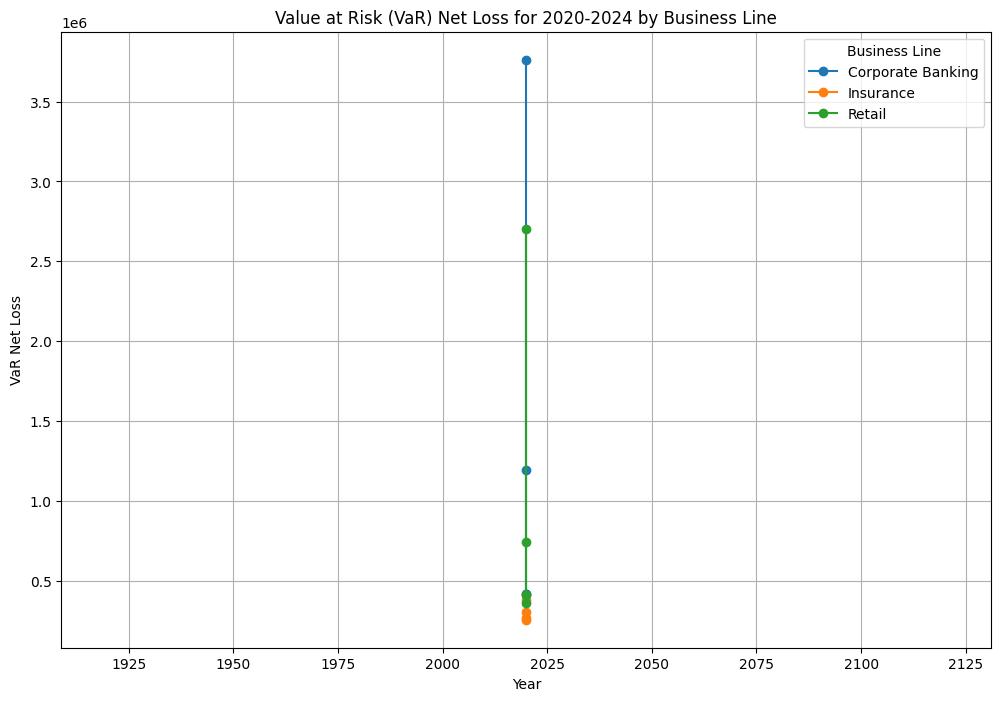

Predicted VaR for 2025:
        Business Line      Event Type  VaR Net Loss  Predicted VaR 2025
0   Corporate Banking      Compliance  3.762345e+06        3.762345e+06
1   Corporate Banking           Fraud  1.191971e+06        1.191971e+06
2   Corporate Banking  System Failure  4.150333e+05        4.150333e+05
3   Corporate Banking           Theft  4.200723e+05        4.200723e+05
4           Insurance      Compliance  3.804521e+05        3.804521e+05
5           Insurance           Fraud  2.563103e+05        2.563103e+05
6           Insurance  System Failure  2.673899e+05        2.673899e+05
7           Insurance           Theft  3.053168e+05        3.053168e+05
8              Retail      Compliance  4.104848e+05        4.104848e+05
9              Retail           Fraud  2.704369e+06        2.704369e+06
10             Retail  System Failure  7.429694e+05        7.429694e+05
11             Retail           Theft  3.628617e+05        3.628617e+05


In [41]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, lognorm
import matplotlib.pyplot as plt

# Define the calculate_var function
def calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    """
    Calculate the Value at Risk (VaR) using Monte Carlo simulation.
    
    Parameters:
    - frequency_lambda (float): The mean rate of events (λ) for Poisson distribution.
    - severity_shape (float): The shape parameter for log-normal distribution.
    - severity_scale (float): The scale parameter for log-normal distribution.
    - severity_loc (float): The location parameter for log-normal distribution.
    - confidence_level (float): Confidence level for VaR (default is 0.999).
    - n_simulations (int): Number of Monte Carlo simulations (default is 10000).
    
    Returns:
    - float: The calculated VaR at the specified confidence level.
    """
    # Simulate event counts based on Poisson
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    # Simulate severity amounts based on Log-Normal
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    
    # Calculate total loss for each simulation
    total_losses = simulated_event_counts * simulated_loss_amounts
    
    # Calculate the VaR at the specified confidence level
    var_value = np.percentile(total_losses, confidence_level * 100)
    
    return var_value

# Load the operational risk dataset
# Replace this with your actual dataset path
df = pd.read_csv('operational_risk_dataset.csv')

# Ensure 'Date' is in datetime format and extract the year
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

# Group by year, business line, and event type
grouped = df.groupby(['Year', 'Business Line', 'Event Type'])

# Initialize a list to hold the results
results = []

# Iterate over each group
for (year, business_line, event_type), group in grouped:
    # Calculate total net loss and event count for the group
    total_net_loss = group['Net Loss Amount'].sum()
    total_event_count = group.shape[0]
    
    # Filter out non-positive values for the severity (log-normal) distribution
    positive_data = group[group['Net Loss Amount'] > 0]['Net Loss Amount']
    
    # Check if we have valid data for fitting
    if len(positive_data) > 0:
        # Estimate parameters for the severity (log-normal) distribution
        severity_shape, severity_loc, severity_scale = lognorm.fit(positive_data, floc=0)
        
        # Calculate VaR for net loss using Monte Carlo simulations
        var_net_loss = calculate_var(total_event_count, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000)
        
        # Append the results
        results.append({
            'Year': year,
            'Business Line': business_line,
            'Event Type': event_type,
            'Total Net Loss': total_net_loss,
            'Total Event Count': total_event_count,
            'VaR Net Loss': var_net_loss
        })
    else:
        print(f"Not enough positive data for fitting log-normal distribution for {year}, {business_line}, {event_type}.")

# Convert the results to a DataFrame
result_df = pd.DataFrame(results)

# Display results
print(result_df)

# Plot the VaR Net Loss for 2020-2024 by Business Line and Event Type
plt.figure(figsize=(12, 8))
for business_line in result_df['Business Line'].unique():
    subset = result_df[result_df['Business Line'] == business_line]
    plt.plot(subset['Year'], subset['VaR Net Loss'], label=business_line, marker='o')
plt.title('Value at Risk (VaR) Net Loss for 2020-2024 by Business Line')
plt.xlabel('Year')
plt.ylabel('VaR Net Loss')
plt.legend(title='Business Line')
plt.grid(True)
plt.show()

# Prediction for 2025 (using historical data to estimate the future VaR)
# For simplicity, we predict based on the last 5 years' average values per business line and event type.
# You can also use more advanced methods like ARIMA, Exponential Smoothing, etc.

# Calculate average VaR per business line and event type
avg_var_2020_2024 = result_df.groupby(['Business Line', 'Event Type'])['VaR Net Loss'].mean().reset_index()

# Add a new column for 2025 prediction (assuming constant VaR for simplicity)
avg_var_2020_2024['Predicted VaR 2025'] = avg_var_2020_2024['VaR Net Loss']

# Display the predicted VaR for 2025
print("Predicted VaR for 2025:")
print(avg_var_2020_2024)


In [40]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats

# Function to generate random dates
def random_dates(start, end, n=10):
    return [start + timedelta(days=np.random.randint(0, (end - start).days)) for _ in range(n)]

# Parameters
num_records = 10000
start_date = datetime.now() - timedelta(days=4*365)
end_date = datetime.now()

# Expanded categories
business_lines = [
    "Retail", "Corporate Banking", "Investment Banking", "Insurance",
    "Wealth Management", "Asset Management", "Private Banking",
    "Credit Card Services", "Mortgage Lending", "Financial Advisory"
]

event_types = [
    "Fraud", "System Failure", "Theft", "Compliance", "Natural Disaster",
    "Cyber Attack", "Market Risk", "Operational Error", "Vendor Risk", "Regulatory Violation"
]

# Generate data
data = {
    "Date": random_dates(start_date, end_date, num_records),
    "Unique Event ID": [f"EID{str(i).zfill(5)}" for i in range(num_records)],
    "Event Type": np.random.choice(event_types, num_records),
    "Business Line": np.random.choice(business_lines, num_records),
    "Event Description": np.random.choice(
        [
            "Unauthorized transaction", "Server downtime", "Lost assets", 
            "Regulatory fines", "Data breach", "Network failure", 
            "Inadequate compliance", "Financial misstatement", 
            "Supplier issues", "Internal fraud"
        ],
        num_records
    ),
    "Net Loss Amount": np.random.choice(
        [np.random.uniform(-10000, 0) for _ in range(num_records // 2)] + 
        [np.random.uniform(0, 10000) for _ in range(num_records // 2)],
        num_records
    )
}

# Create DataFrame
df = pd.DataFrame(data)

# Add a Year column
df['Year'] = df['Date'].dt.year

# Function to fit distribution and calculate VaR for the specified confidence level
def fit_distribution_and_calculate_var(data):
    confidence = 0.999  # Set to 99.9%
    var_result = {}
    # Filter only negative net loss amounts for fitting
    negative_losses = data[data['Net Loss Amount'] < 0]
    
    if negative_losses.empty:
        return {confidence: np.nan}  # Return NaN if no data

    # Fit a log-normal distribution to the net loss amounts (inverted for fitting)
    shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)  
    # Calculate VaR for the specified confidence level
    var = stats.lognorm.ppf(confidence, shape, loc=loc, scale=scale)
    var_result[confidence] = var
    return var_result

# Group by Year, Business Line, and Event Type, then apply the VaR calculation
result = df.groupby(['Year', 'Business Line', 'Event Type']).apply(
    lambda x: fit_distribution_and_calculate_var(x)[0.999]
).reset_index()

result.columns = ['Year', 'Business Line', 'Event Type', 'VaR (99.9%)']

# Calculate total loss amount and count of event IDs for each group
agg_result = df.groupby(['Year', 'Business Line', 'Event Type']).agg(
    Total_Loss_Amount=('Net Loss Amount', 'sum'),
    Event_Count=('Unique Event ID', 'count')
).reset_index()

# Merge VaR results with aggregated results
final_result = pd.merge(agg_result, result, on=['Year', 'Business Line', 'Event Type'], how='left')

# Display the final results
print(final_result)

# Optionally, save results to a CSV
final_result.to_csv('lda_var_results_with_totals_99.9.csv', index=False)


FitDataError: Invalid values in `data`.  Maximum likelihood estimation with 'lognorm' requires that 0.0 < (x - loc)/scale  < inf for each x in `data`.

In [42]:
final_result

,Year,Business Line,Event Type,Total_Loss_Amount,Event_Count,VaR (99.9%)
0,2020,Asset Management,Compliance,1210.646097,4,5.108877e+03
1,2020,Asset Management,Fraud,2488.143000,2,1.606215e+03
2,2020,Asset Management,Market Risk,-6240.615813,2,3.073744e+21
3,2020,Asset Management,Natural Disaster,-15638.488274,3,4.393410e+22
4,2020,Asset Management,Regulatory Violation,-1661.368351,3,3.381890e+19
...,...,...,...,...,...,...
466,2024,Wealth Management,Operational Error,14124.943368,15,1.079078e+19
467,2024,Wealth Management,Regulatory Violation,-2182.151802,19,1.565469e+17
468,2024,Wealth Management,System Failure,-6622.756005,30,2.480636e+04
469,2024,Wealth Management,Theft,-18160.713335,25,1.279362e+04
